In [3]:
!python -m venv --copies awalk55

In [4]:
%cd /mnt/beegfs/labs/bozkurtlab/drew-projects/loneliness-ehr/
%ls

/mnt/beegfs/labs/bozkurtlab/drew-projects/loneliness-ehr
acute_sample_size_vs_f1_score_naive_bayes.csv
acute_social_disconnection_sample_size_vs_f1_score.png
acute_social_isolation_llm_labeled.csv
acute_social_isolation_llm_one_shot_labeled.csv
acute_social_isolation_llm_three_shot_labeled.csv
acute_social_isolation_results.csv
ajudication-reliability-files/
annotation_Drew_sample_social_disconnection_DW.csv
annotation_Selen_sample_social_disconnection_SB.csv
awalk55/
chronic_social_isolation_llm_3_shot_labeled.csv
chronic_social_isolation_llm_labeled.csv
chronic_social_isolation_llm_one_shot_labeled.csv
chronic_social_isolation_results.csv
gold_standard_social_isolation_1000.csv
lives_alone_results.csv
lives_alone_sample_size_vs_f1_score.png
lives_alone_social_isolation_llm_labeled.csv
lives_alone_social_isolation_llm_one_shot_labeled.csv
lives_alone_social_isolation_llm_three_shot_labeled.csv
lives_alone_social_isolation_results.csv
sample_size_vs_f1_score.csv
summary_models_acute_so

/opt/modules/Python/3.11.5/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
!pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [6]:
import requests
import pandas as pd
import numpy as np
import sentencepiece
from transformers import LlamaTokenizer
%ls

/home/awalk55/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


acute_sample_size_vs_f1_score_naive_bayes.csv
acute_social_disconnection_sample_size_vs_f1_score.png
acute_social_isolation_llm_labeled.csv
acute_social_isolation_llm_one_shot_labeled.csv
acute_social_isolation_llm_three_shot_labeled.csv
acute_social_isolation_results.csv
ajudication-reliability-files/
annotation_Drew_sample_social_disconnection_DW.csv
annotation_Selen_sample_social_disconnection_SB.csv
awalk55/
chronic_social_isolation_llm_3_shot_labeled.csv
chronic_social_isolation_llm_labeled.csv
chronic_social_isolation_llm_one_shot_labeled.csv
chronic_social_isolation_results.csv
gold_standard_social_isolation_1000.csv
lives_alone_results.csv
lives_alone_sample_size_vs_f1_score.png
lives_alone_social_isolation_llm_labeled.csv
lives_alone_social_isolation_llm_one_shot_labeled.csv
lives_alone_social_isolation_llm_three_shot_labeled.csv
lives_alone_social_isolation_results.csv
sample_size_vs_f1_score.csv
summary_models_acute_social_isolation.csv
summary_models_chronic_social_isolatio

In [8]:
# Read the Annie Sample csv file
df1 = pd.read_csv("annotation_Selen_sample_social_disconnection_SB.csv") #Selen Sample

# Read the Drew Sample csv file
df2 = pd.read_csv("annotation_Drew_sample_social_disconnection_DW.csv") #Drew Sample
# Bind the rows of the two dataframes

In [9]:
## Read in reliability and ajudications
# reliability for 100
df_reliability = pd.read_csv("ajudication-reliability-files/ajudications_reliability_social_disconnection_agree.csv",encoding="latin1")

# ajudication dfs for disagreements 
acute_aju = pd.read_csv("ajudication-reliability-files/ajudications_acute_disagreements_dw.csv",encoding="latin1")
chronic_aju = pd.read_csv("ajudication-reliability-files/ajudications_chronic_disagreements_dw.csv",encoding="latin1")
live_alone_aju = pd.read_csv("ajudication-reliability-files/ajudications_lives_alone_disagreements_dw.csv",encoding="latin1")

df_reliability.info()

#ajudication dataframes
acute_aju.info()
chronic_aju.info()
live_alone_aju.info()

# keep only sentence_id and ajudication columns in ajudication dataframes
keep = ['sentence_id', 'adjudication']

# Keep only 'sentence_id' and 'adjudication' columns
acute_aju_trimmed = acute_aju[keep]
chronic_aju_trimmed = chronic_aju[keep]
live_alone_aju_trimmed = live_alone_aju[keep]

# Merge acute_aju, chronic_aju, live_alone_aju with df_reliability based on 'sentence_id'
df_merged = df_reliability.merge(acute_aju_trimmed, on='sentence_id', how='left', suffixes=('', '_acute_aju')) \
                          .merge(chronic_aju_trimmed, on='sentence_id', how='left', suffixes=('', '_chronic_aju')) \
                          .merge(live_alone_aju_trimmed, on='sentence_id', how='left', suffixes=('', '_live_alone_aju'))


# Merge in ajudications for nonagreement 
# for any row =0 for chronic_label_agree, make chronic_social_disconnection_label = adjudication. For any row =0 for lives_alone_agree, make lives_alone_label = adjudication . For any row = 0 for acute_label_agree, make acute_social_disconnection_label = adjudication.

# For rows where chronic_label_agree == 0, replace chronic_social_disconnection_label with adjudication from chronic_aju
df_merged['chronic_social_disconnection_label'] = df_merged.apply(
    lambda row: row['adjudication_chronic_aju'] if row['chronic_label_agree'] == 0 else row['chronic_social_disconnection_label'], axis=1
)

# For rows where lives_alone_agree == 0, replace lives_alone_label with adjudication from live_alone_aju
df_merged['lives_alone_label'] = df_merged.apply(
    lambda row: row['adjudication_live_alone_aju'] if row['lives_alone_agree'] == 0 else row['lives_alone_label'], axis=1
)

# For rows where acute_label_agree == 0, replace acute_social_disconnection_label with adjudication from acute_aju
df_merged['acute_social_disconnection_label'] = df_merged.apply(
    lambda row: row['adjudication_acute_aju'] if row['acute_label_agree'] == 0 else row['acute_social_disconnection_label'], axis=1
)

df_merged.info()  # Check the structure of the merged DataFrame
df_merged[df_merged['lives_alone_agree'] == 0].head(100)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   sentence_id                           100 non-null    int64  
 1   text                                  100 non-null    object 
 2   sentence                              100 non-null    object 
 3   matched_term                          100 non-null    object 
 4   chronic_social_disconnection_label    100 non-null    int64  
 5   lives_alone_label                     100 non-null    int64  
 6   acute_social_disconnection_label      100 non-null    int64  
 7   annotator_comments                    5 non-null      object 
 8   manuscript_example                    1 non-null      object 
 9   chronic_social_disconnection_label_2  100 non-null    int64  
 10  lives_alone_label_2                   100 non-null    int64  
 11  acute_social_disconn

,sentence_id,text,sentence,matched_term,chronic_social_disconnection_label,lives_alone_label,acute_social_disconnection_label,annotator_comments,manuscript_example,chronic_social_disconnection_label_2,...,chronic_label_agree,lives_alone_agree,acute_label_agree,adjudication,adjudication_rationale,adjudication_2,adjudication_rationale_2,adjudication_acute_aju,adjudication_chronic_aju,adjudication_live_alone_aju
21,5555625,Pt is a 62yof w/ hx of Schizophrenia who pres...,TOL WELL.SOCIAL SERVICE CONSULT FOR HOMELESSNE...,estranged,1.0,0.0,0.0,NaN,NaN,1,...,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0
23,9739007,T/SICU RN Admit/Progress Note\nPt. 66y/o femal...,Social: Found down in apartment alone.,alone,0.0,0.0,0.0,maybe 0 for lives alone actually,NaN,0,...,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0
36,4954645,PMH: Atrial flutter w/ failed ablation now in ...,"PT ALERT,OX3 ,COOPERATIVE .NOW IN SR NO ECTOPY...",lives alone,0.0,1.0,0.0,NaN,NaN,0,...,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [10]:
# Filter rows where annotator_comments or annotator_comments_2 are not NA or blank
df_merged_filtered_comments = df_merged[
    (df_merged['annotator_comments'].notna()) & (df_merged['annotator_comments'] != '') |
    (df_merged['annotator_comments_2'].notna()) & (df_merged['annotator_comments_2'] != '')
]

# Filter rows where manuscript_example or manuscript_example_2 are not NA or blank
df_merged_filtered_manuscripts = df_merged[
    (df_merged['manuscript_example'].notna()) & (df_merged['manuscript_example'] != '') |
    (df_merged['manuscript_example_2'].notna()) & (df_merged['manuscript_example_2'] != '')
]
df_merged_filtered_comments
df_merged_filtered_manuscripts

,sentence_id,text,sentence,matched_term,chronic_social_disconnection_label,lives_alone_label,acute_social_disconnection_label,annotator_comments,manuscript_example,chronic_social_disconnection_label_2,...,chronic_label_agree,lives_alone_agree,acute_label_agree,adjudication,adjudication_rationale,adjudication_2,adjudication_rationale_2,adjudication_acute_aju,adjudication_chronic_aju,adjudication_live_alone_aju
43,6756039,"1900-0700 NPN\nNEURO: Awake and alert, states...","1900-0700 NPN NEURO: Awake and alert, states h...",lonely,1.0,0.0,1.0,"may be more acute, unclear if chronic",NaN,1,...,0,1,0,NaN,NaN,NaN,NaN,1.0,1.0,NaN
83,18016293,SW referred by RN to provide support to this 7...,"Pt reports feeling depressed lately, he notes ...",loneliness,1.0,0.0,1.0,Full text is extremely descriptive of social s...,yes,1,...,1,1,0,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [11]:
df = pd.concat([df1, df2], ignore_index=True)
# clean up more
df


# Add in the ajudicated reliability df 

# Step 1: Rename the columns in df_merged based on your mapping
merged_df = df_merged.rename(columns={
    'sentence_id': 'Sentence ID',
    'text': 'TEXT',
    'sentence': 'Sentence',
})

# Step 2: Select the specific columns from merged_df and df
merged_df_cols = ['Sentence ID', 'TEXT', 'Sentence', 'matched_term', 
                  'chronic_social_disconnection_label', 'lives_alone_label', 'acute_social_disconnection_label']

# Select the columns for both datasets
df_merged_selected = merged_df[merged_df_cols]
df_selected = df[merged_df_cols]

# Step 3: Concatenate the two DataFrames
df_concat = pd.concat([df_merged_selected, df_selected], axis=0, ignore_index=True)

# Replacing blank or NA values with 0 in the specified columns
df_concat[['chronic_social_disconnection_label', 'acute_social_disconnection_label', 'lives_alone_label']] = df_concat[
    ['chronic_social_disconnection_label', 'acute_social_disconnection_label', 'lives_alone_label']
].fillna(0).replace('', 0)

# Displaying the updated DataFrame
df_concat.head()



cols = ['Sentence', 'TEXT']
df_concat['full_text'] = df_concat[cols].apply(lambda row: '</s>'.join(row.values.astype(str)), axis=1)

# Function to truncate full_text to a maximum number of words (tokens approximation)
def truncate_to_8000_words(text, max_words=6000):
    # Split the text into words (tokens are often split similarly)
    words = text.split()

    # Truncate to the first max_words if necessary
    if len(words) > max_words:
        words = words[:max_words]

    # Join back into a string
    truncated_text = ' '.join(words)
    
    return truncated_text

# Apply the truncation function to each row in the dataframe
df_concat['full_text_truncated'] = df_concat['full_text'].apply(lambda x: truncate_to_8000_words(x))



df_concat.info()
df_concat.head()
df_concat.to_csv("gold_standard_social_isolation_1000.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Sentence ID                         1000 non-null   int64  
 1   TEXT                                1000 non-null   object 
 2   Sentence                            1000 non-null   object 
 3   matched_term                        1000 non-null   object 
 4   chronic_social_disconnection_label  1000 non-null   float64
 5   lives_alone_label                   1000 non-null   float64
 6   acute_social_disconnection_label    1000 non-null   float64
 7   full_text                           1000 non-null   object 
 8   full_text_truncated                 1000 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 70.4+ KB


In [12]:
# lives_alone_label, acute_social_disconnection_label
# Chronic social isolation classifier
chronic_df = df_concat[['full_text_truncated', 'chronic_social_disconnection_label']]

# Display the first few rows of chronic_df
chronic_df.info()
chronic_df.head()
unique_chronic_values = chronic_df['chronic_social_disconnection_label'].value_counts().reset_index()

# Renaming columns for clarity
unique_chronic_values.columns = ['chronic_social_disconnection_label', 'count']
unique_chronic_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   full_text_truncated                 1000 non-null   object 
 1   chronic_social_disconnection_label  1000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


,chronic_social_disconnection_label,count
0,0.0,968
1,1.0,32


In [13]:
%pip install seaborn
%pip install nltk

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
train_size = 0.8
train_data=chronic_df.sample(frac=train_size,random_state=0)
test_data=chronic_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

print("FULL Dataset: {}".format(df_concat.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

FULL Dataset: (1000, 9)
TRAIN Dataset: (800, 2)
TEST Dataset: (200, 2)


In [13]:
import requests
import pandas as pd
from datetime import datetime
import time

start_time = time.time()

def request(query):
    # Define the headers
    headers = {
        'Content-Type': 'application/json'
    }
    
    # Define the data
    data = {
        "model": model_name,
        "prompt": query,
        "max_tokens": max_tokens,
        "temperature": 1,
        "top_p": 0.95,
    }
    
    # Make the POST request
    response = requests.post(url, headers=headers, json=data)
    
    # Check if the response is successful
    if response.status_code == 200:
        response_json = response.json()
        
        # Check if the 'choices' key exists
        if 'choices' in response_json:
            answer = response_json['choices'][0]['text']
            print('Answer:\n', answer)
            return answer
        else:
            print("Error: 'choices' key not found in the response.")
            print("Full response content:", response_json)
            return None
    else:
        print(f"Error: Received status code {response.status_code}")
        print("Response content:", response.content)
        return None

def process_dataframe(df, model_name, max_tokens, url):
    results = []
    
    for index, row in df.iterrows():
        prompt = f'''
        You are an expert in abstracting social health from medical language, focused on studying the documentation of social isolation and loneliness within an intensive care unit's electronic health record.
        Read the following sentence, appended by </s> and the full patient note text, and respond with a 1 or 0. Respond with “1” if the chart describes or alludes to a patient suffering from ongoing social isolation or loneliness. This would be any text relating to a patients' potential feelings of their social interaction/support needs not being met in general or over an extended period of time. 
        Respond with “0” if the chart does not, if there is not enough evidence of loneliness or social isolation in the chart, or if you are otherwise unsure. 
        After the response, write a short sentence describing the rationale behind the 1/0 classification.
        
        Read the following sentence matching a related keyword, which is appended by </s> and followed by the entire chart carefully:
        {row['full_text_truncated']}
        Please strictly format each response beginning with "Response:" followed by either 0 or 1, then "Rationale:" followed by your explanation.'''
        
        answer = request(prompt)
        if answer is not None:
            results.append({'full_text_truncated': row['full_text_truncated'], 'label_model': answer, 'gold_label': row['chronic_social_disconnection_label']})
        else:
            results.append({'full_text_truncated': row['full_text_truncated'], 'label_model': 'Error', 'gold_label': row['chronic_social_disconnection_label']})
    
    return pd.DataFrame(results)

# Model parameters
model_name = 'meta-llama/Meta-Llama-3-70B-Instruct'
max_tokens = 100
url = 'http://llm1.priv.bmi.emory.edu:8000/llama3_70B/v1/completions'


# Process the DataFrame
result_df = process_dataframe(test_data, model_name, max_tokens, url)

print(result_df)
end_time = time.time()
duration = end_time - start_time
print(f"{duration} seconds")


Answer:
   
        Thank you.
Error: Received status code 400
Response content: b'{"object":"error","message":"This model\'s maximum context length is 8192 tokens. However, you requested 9137 tokens (9037 in the messages, 100 in the completion). Please reduce the length of the messages or completion.","type":"BadRequestError","param":null,"code":400}'
Answer:
    
        Response: 0
        Rationale: This chart describes a patient being cooperative but withdrawn, which could potentially be related to loneliness or social isolation; however, it also specifically notes that the patient has a supportive partner and family members at their bedside. This suggests that their social support needs are being met, and the withdrawn behavior may be related to their medical condition rather than social isolation.
Answer:
 
Answer:
  



        Response: 0
        Rationale: There is no mention of the patient feeling socially isolated or lonely in the chart. The patient's family is involved in 

In [14]:
# Parse responses
import re

# Function to extract the first number (0 or 1) after 'Response:'
def extract_response(text):
    start = text.find("Response:") + len("Response:")
    if start != -1:
        # Extract the text following "Response:"
        text_after_response = text[start:].strip()
        # Use regex to find the first occurrence of 0 or 1
        match = re.search(r'\b[01]\b', text_after_response)
        if match:
            return int(match.group())  # Return the number found (0 or 1)
    return 0  # Default to 0 if no valid response is found

# Function to extract the rationale (all text following 'Rationale:')
def extract_rationale(text):
    start = text.find("Rationale:") + len("Rationale:")
    if start != -1:
        return text[start:].strip()
    return ""  # Return empty string if "Rationale:" is not found

# Apply the functions to create new columns
result_df['response'] = result_df['label_model'].apply(extract_response)
result_df['rationale'] = result_df['label_model'].apply(extract_rationale)



In [15]:
result_df
result_df['response'].value_counts()
result_df['gold_label'].value_counts()

gold_label
0.0    196
1.0      4
Name: count, dtype: int64

In [16]:
result_df.to_csv("chronic_social_isolation_llm_labeled.csv")

In [2]:
result_df = pd.read_csv("chronic_social_isolation_llm_labeled.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'chronic_social_isolation_llm_labeled.csv'

In [18]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

classificaiton_report = classification_report(result_df['gold_label'],result_df['response'])

print(classificaiton_report)

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91       196
         1.0       0.06      0.50      0.11         4

    accuracy                           0.84       200
   macro avg       0.53      0.67      0.51       200
weighted avg       0.97      0.84      0.90       200



In [19]:
results = []

for _ in range(1000):
    sample_df = result_df.sample(len(result_df), replace=True)

    preds = sample_df['response'].values
    true_labels = sample_df['gold_label'].values

    accuracy = accuracy_score(true_labels, preds)
    positive_precision = precision_score(true_labels, preds, labels=[1], average='binary')
    positive_recall = recall_score(true_labels, preds, labels=[1], average='binary')
    positive_f1 = f1_score(true_labels, preds, labels=[1], average='binary')

    results.append({
        'Accuracy': accuracy,
        'Positive Precision': positive_precision,
        'Positive Recall': positive_recall,
        'Positive F1': positive_f1,
    })

results_df = pd.DataFrame(results)

# Calculate mean
mean_summary = results_df.mean()

# Calculate confidence intervals
ci_lower = results_df.apply(lambda x: np.percentile(x, 2.5))
ci_upper = results_df.apply(lambda x: np.percentile(x, 97.5))

# Combine mean and confidence intervals into a single DataFrame
summary = pd.DataFrame({
    'Mean': mean_summary,
    '2.5%': ci_lower,
    '97.5%': ci_upper
})

print(summary)



/home/awalk55/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/awalk55/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/awalk55/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/awalk55/.local/lib/python3.11/site-packages/sklearn/metrics/_

                        Mean   2.5%     97.5%
Accuracy            0.838910  0.785  0.885000
Positive Precision  0.062792  0.000  0.156344
Positive Recall     0.490727  0.000  1.000000
Positive F1         0.108910  0.000  0.263158


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score, make_scorer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sn
import os
import nltk
from datetime import datetime
import time


skf = StratifiedKFold(n_splits=5)
X = chronic_df['full_text_truncated'].values
y = chronic_df['chronic_social_disconnection_label'].values

metrics = []

skf = StratifiedKFold(n_splits=5)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    vect = CountVectorizer(ngram_range=(1, 2), max_features=10000, stop_words="english")
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)


# Define the parameter grids for Naive Bayes, Random Forest, and Logistic Regression
nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0],  # Different alpha values for MultinomialNB
}

rf_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
}

lr_param_grid = {
    'C': [0.01, 0.1, 1.0],  # Regularization parameter for Logistic Regression
}

# Create a list to store the results
results = []

# Define a custom scoring function to prioritize precision for the positive class
positive_precision_scorer = make_scorer(precision_score, labels=[1], average='binary',  zero_division = 0)
positive_recall_scorer = make_scorer(recall_score, labels=[1], average='binary',  zero_division = 0)
positive_f1_scorer = make_scorer(f1_score, labels=[1], average='binary',  zero_division = 0)


# Perform grid search for Naive Bayes
nb_grid_search = GridSearchCV(MultinomialNB(), nb_param_grid, cv=5, scoring='accuracy', verbose=1)
start_time = time.time()
nb_grid_search.fit(X_train_dtm, y_train)
end_time = time.time()
duration = end_time - start_time

# Get the best hyperparameters and the corresponding model
best_nb_model = nb_grid_search.best_estimator_
best_nb_params = nb_grid_search.best_params_

# Evaluate the Naive Bayes model on the test set
nb_test_predictions = best_nb_model.predict(X_test_dtm)
nb_accuracy = accuracy_score(y_test, nb_test_predictions)
nb_positive_precision = precision_score(y_test, nb_test_predictions, labels=[1], average='binary',  zero_division = 0)
nb_positive_recall = recall_score(y_test, nb_test_predictions, labels=[1], average='binary',  zero_division = 0)
nb_positive_f1 = f1_score(y_test, nb_test_predictions, labels=[1], average='binary',  zero_division = 0)


# Store the results for Naive Bayes
results.append({
    'Model': 'Multinomial Naive Bayes',
    'Hyperparameters': best_nb_params,
    'Accuracy': nb_accuracy,
    'Positive Precision': nb_positive_precision,
    'Positive Recall': nb_positive_recall,
    'Positive F1': nb_positive_f1,
    'Timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Duration (s)': duration
})

# Perform grid search for Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=1), rf_param_grid, cv=5, scoring='accuracy', verbose=1)
start_time = time.time()
rf_grid_search.fit(X_train_dtm, y_train)
end_time = time.time()
duration = end_time - start_time

# Get the best hyperparameters and the corresponding model
best_rf_model = rf_grid_search.best_estimator_
best_rf_params = rf_grid_search.best_params_

# Evaluate the Random Forest model on the test set
rf_test_predictions = best_rf_model.predict(X_test_dtm)
rf_accuracy = accuracy_score(y_test, rf_test_predictions)
rf_positive_precision = precision_score(y_test, rf_test_predictions, labels=[1], average='binary',zero_division = 0)
rf_positive_recall = recall_score(y_test, rf_test_predictions, labels=[1], average='binary', zero_division = 0)
rf_positive_f1 = f1_score(y_test, rf_test_predictions, labels=[1], average='binary',  zero_division = 0)


# Store the results for Random Forest
results.append({
    'Model': 'Random Forest',
    'Hyperparameters': best_rf_params,
    'Accuracy': rf_accuracy,
    'Precision': rf_positive_precision,
    'Recall': rf_positive_recall,
    'F1': rf_positive_f1,
    'Timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Duration (s)': duration
})

# Perform grid search for Logistic Regression
lr_grid_search = GridSearchCV(LogisticRegression(max_iter=1000), lr_param_grid, cv=5, scoring='accuracy', verbose=1)
start_time = time.time()
lr_grid_search.fit(X_train_dtm, y_train)
end_time = time.time()
duration = end_time - start_time

# Get the best hyperparameters and the corresponding model
best_lr_model = lr_grid_search.best_estimator_
best_lr_params = lr_grid_search.best_params_

# Evaluate the Logistic Regression model on the test set
lr_test_predictions = best_lr_model.predict(X_test_dtm)
lr_accuracy = accuracy_score(y_test, lr_test_predictions)
lr_positive_precision = precision_score(y_test, lr_test_predictions, labels=[1], average='binary',  zero_division = 0)
lr_positive_recall = recall_score(y_test, lr_test_predictions, labels=[1], average='binary',  zero_division = 0)
lr_positive_f1 = f1_score(y_test, lr_test_predictions, labels=[1], average='binary',  zero_division = 0)


# Store the results for Logistic Regression
results.append({
    'Model': 'Logistic Regression',
    'Hyperparameters': best_lr_params,
    'Accuracy': lr_accuracy,
    'Positive Precision': lr_positive_precision,
    'Positive Recall': lr_positive_recall,
    'Positive F1': lr_positive_f1,
    'Timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Duration (s)': duration
})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Save the results to a CSV file
results_df.to_csv('chronic_social_isolation_results.csv', index=False)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
                     Model                                    Hyperparameters  \
0  Multinomial Naive Bayes                                     {'alpha': 0.1}   
1            Random Forest  {'max_depth': None, 'min_samples_split': 2, 'n...   
2      Logistic Regression                                        {'C': 0.01}   

   Accuracy  Positive Precision  Positive Recall  Positive F1  \
0     0.890            0.142857         0.428571     0.214286   
1     0.965                 NaN              NaN          NaN   
2     0.960            0.000000         0.000000     0.000000   

             Timestamp  Duration (s)  Precision  Recall   F1  
0  2024-10-06 22:02:33      0.068294        NaN     NaN  NaN  
1  2024-10-06 22:03:40     67.502539        0.0     0.0  0.0  
2  2024-10-06 22:03:42      1.668880       

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Placeholder for best hyperparameters (you can modify these values)
best_nb_params = {'alpha': .1}
best_rf_params = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}
best_lr_params = {'C': .01}

X = chronic_df['full_text_truncated'].values
y = chronic_df['chronic_social_disconnection_label'].values


skf = StratifiedKFold(n_splits=5)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    vect = CountVectorizer(ngram_range=(1, 2), max_features=10000, stop_words="english")
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)

    # Train and predict using the models
    models = {
        "Multinomial Naive Bayes": MultinomialNB(**best_nb_params),
        "Random Forest": RandomForestClassifier(random_state=1, **best_rf_params),
        "Logistic Regression": LogisticRegression(max_iter=1000, **best_lr_params)
    }

    predictions = {}

    for model_name, model in models.items():
        model.fit(X_train_dtm, y_train)
        preds = model.predict(X_test_dtm)
        predictions[model_name] = preds

    # Convert predictions to DataFrame
    predicted_df = pd.DataFrame(predictions)
    predicted_df['True Label'] = y_test

    results = []

    # Bootstrap by randomly sampling from predicted_df
    for _ in range(1000):
        sample_df = predicted_df.sample(len(predicted_df), replace=True)

        for model_name in models.keys():
            preds = sample_df[model_name].values
            true_labels = sample_df['True Label'].values

            accuracy = accuracy_score(true_labels, preds)
            positive_precision = precision_score(true_labels, preds, labels=[1], average='binary',  zero_division = 0)
            positive_recall = recall_score(true_labels, preds, labels=[1], average='binary',  zero_division = 0)
            positive_f1 = f1_score(true_labels, preds, labels=[1], average='binary',  zero_division = 0)

            results.append({
                'Model': model_name,
                'Accuracy': accuracy,
                'Positive Precision': positive_precision,
                'Positive Recall': positive_recall,
                'Positive F1': positive_f1,
            })

    results_df = pd.DataFrame(results)

    # Calculate mean and confidence intervals
    summary = results_df.groupby('Model').agg({
        metric: ['mean', lambda x: np.percentile(x, 2.5), lambda x: np.percentile(x, 97.5)]
        for metric in ['Accuracy', 'Positive Precision', 'Positive Recall', 'Positive F1']
    })

    print(summary)

summary

summary.to_csv("summary_models_chronic_social_isolation.csv")



                         Accuracy                       Positive Precision  \
                             mean <lambda_0> <lambda_1>               mean   
Model                                                                        
Logistic Regression      0.970245      0.945       0.99           0.000000   
Multinomial Naive Bayes  0.940160      0.905       0.97           0.197071   
Random Forest            0.970245      0.945       0.99           0.000000   

                                              Positive Recall             \
                        <lambda_0> <lambda_1>            mean <lambda_0>   
Model                                                                      
Logistic Regression            0.0        0.0        0.000000        0.0   
Multinomial Naive Bayes        0.0        0.5        0.324024        0.0   
Random Forest                  0.0        0.0        0.000000        0.0   

                                   Positive F1                        
   

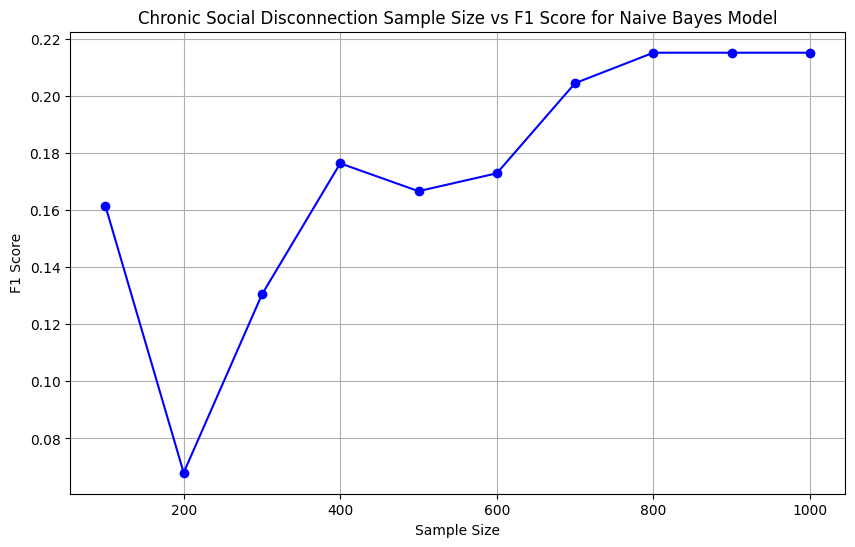

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Assuming chronic_df is already loaded and available
X = chronic_df['full_text_truncated'].values
y = chronic_df['chronic_social_disconnection_label'].values

skf = StratifiedKFold(n_splits=5)

# Empty lists to store sample sizes and F1 scores for the Naive Bayes model
sample_sizes = []
f1_scores = []

# Loop through different sample sizes
for sample_size in range(100, 1001, 100):
    f1_scores_sample = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Use only the first `sample_size` samples for training
        X_train_sampled = X_train[:sample_size]
        y_train_sampled = y_train[:sample_size]

        # Use CountVectorizer to transform the text data
        vect = CountVectorizer(ngram_range=(1, 2), max_features=10000, stop_words="english")
        X_train_dtm = vect.fit_transform(X_train_sampled)
        X_test_dtm = vect.transform(X_test)

        # Instantiate and train the Naive Bayes model
        model = MultinomialNB(alpha=0.1)  # Use your desired hyperparameters
        model.fit(X_train_dtm, y_train_sampled)
        
        # Make predictions on the test set
        preds = model.predict(X_test_dtm)

        # Calculate F1 score
        f1 = f1_score(y_test, preds, pos_label=1)
        f1_scores_sample.append(f1)

    # Store the mean F1 score for this sample size
    sample_sizes.append(sample_size)
    f1_scores.append(np.mean(f1_scores_sample))

# Create a DataFrame for the results
results_df = pd.DataFrame({'Sample Size': sample_sizes, 'F1 Score': f1_scores})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Sample Size'], results_df['F1 Score'], marker='o', linestyle='-', color='b')
plt.title('Chronic Social Disconnection Sample Size vs F1 Score for Naive Bayes Model')
plt.xlabel('Sample Size')
plt.ylabel('F1 Score')
plt.grid(True)
# Save the figure as a PNG file
file_path = 'chronic_social_disconnection_sample_size_vs_f1_score.png'
plt.savefig(file_path)
# Save results to CSV
results_df.to_csv("chronic_sample_size_vs_f1_score_naive_bayes.csv", index=False)


In [35]:
# Regex 
df_concat['regex_label'] = 1.0
df_concat.head()
# REGEX values 

results = []

for _ in range(1000):
    sample_df = df_concat.sample(len(df_concat), replace=True)

    preds = df_concat['regex_label'].values
    true_labels = df_concat['chronic_social_disconnection_label'].values

    accuracy = accuracy_score(true_labels, preds)
    positive_precision = precision_score(true_labels, preds, labels=[1], average='binary')
    positive_recall = recall_score(true_labels, preds, labels=[1], average='binary')
    positive_f1 = f1_score(true_labels, preds, labels=[1], average='binary')
    results.append({
        'Accuracy': accuracy,
        'Positive Precision': positive_precision,
        'Positive Recall': positive_recall,
        'Positive F1': positive_f1,
    })

df_concat_df = pd.DataFrame(results)

# Calculate mean
mean_summary = df_concat_df.mean()

# Calculate confidence intervals
ci_lower = df_concat_df.apply(lambda x: np.percentile(x, 2.5))
ci_upper = df_concat_df.apply(lambda x: np.percentile(x, 97.5))

# Combine mean and confidence intervals into a single DataFrame
summary = pd.DataFrame({
    'Mean': mean_summary,
    '2.5%': ci_lower,
    '97.5%': ci_upper
})

print(summary)

                        Mean      2.5%     97.5%
Accuracy            0.032000  0.032000  0.032000
Positive Precision  0.032000  0.032000  0.032000
Positive Recall     1.000000  1.000000  1.000000
Positive F1         0.062016  0.062016  0.062016
